# Long Short Term Memory (LSTM) Models

This tutorial walks through programming a Long Short Term Memory Model in Python from scratch using only the numpy library for matrix operations, with an application to language models. The backpropogation steps are explicitly derived.

## Introduction 

In speech, recent words might be better to predict the next word in a sentence. But sometimes, words from longer time horizons in the past might be important for prediction. For example, if we start talking about the LA Lakers and I say, "Kobe Bryant is the greatest of all -" and then stop talking, a die hard fan might scream out "TIME!". Two things may have prompted this response: 1) the fact I had mentioned Kobe Bryant to begin with, making you think of the greatest of the greats to ever play the game, hence thinking "of all time". And 2) The word "time" might typically follow the phrase "greatest of all time". But what if we weren't talking about all players before, but our conversation was strictly about shooting guards. Then maybe the proper response would be "greatest of all shooting guards to ever play the game". 

The immediate past as well as the far past (beginning of our hour long basketball conversation) might be important to predict the next word.

Long Short Term Memory Models seem properly fit to train a language model that can have a memory, i.e. forget unnecessary information in the conversation history and bring its attention to relevant information, be it from the immediate past or further back in time.

## Reading 

Now would be a good time to mention that LSTM models have been around for a few years and there are a lot of very useful tutorials online which are much better at explaining the inner workings of the model. 

1. [Christopher Olah has a great explanation with clear diagrams](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

2. [Nico Jimenez's page is what motivated this speech based version of his code](http://nicodjimenez.github.io/2014/08/08/lstm.html)

3. [Arun Mallya's clean presentation about LSTM's helped my understanding of the backpropogation](http://arunmallya.github.io/writeups/nn/lstm/index.html#/)

After reading these articles, I think the rest of the tutorial will follow.

### Differences with this tutorial
I had a hard time understanding the backpropogation of LSTM's for speech models. The main difference with this tutorial is twofold  

1. Illustrate how you can program LSTMs for sentences. Say you have a bunch of sentences, and you want to develop a LSTM model for language, maybe for a chatbot or generative robot. This tutorial is to show you one way of quantifying the words/sentences as examples and training the model.

2. Because the focus is on speech, the output to the LSTM is a distribution over words in the vocabulary. Hence, the activation function on the output is a [softmax](https://en.wikipedia.org/wiki/Softmax_function) function. The backpropogration was not entirely clear from previous tutorials so I explicitly derive the formulas below for additional clarity.

## Forward Propogation 

The main idea behind an LSTM is to have a cell state running throughout the entire sentence, and this cell state will be updated after the introduction of each new word to the sentence. The reason this will be useful is because it allows us to include memory into the model. 

The LSTM language model will start off by taking in a one-hot encoded vector for the first word in the sentence, $x_0$, say "Kobe". With this, we will create a hidden state and cell state for $t=0$.

At each time period (or introduction of new word in our case), the LSTM model will compute three gates: a forget gate, an input gate, and an output gate. As an example, suppose we heard the word "Kobe" at $t=0$ and are now at $t=1$, where the word "Bryant" was just said. The one-hot encoded vector "Bryant" will be $x_1$.

The forget gate tells us how much to forget from time $t=0$'s cell state. So, maybe the first word at $t=0$ was "Kobe", and the abstract cell space put a lot of weight on the words "Beef" and "Bryant". Once we get the word "Bryant" at $t=1$, we should forget anything in the cell state putting weight on "Beef". 

The input gate tells us how much weight should be put on the new information from the current word given. What if we are at $t=1$, and instead of "Bryant" we now hear "uhhhhhhh". We know this is a filler word so we should not put much weight on it. The input gate will be a vector of small weights so $x_1$ vector "uhhhhhhh" doesn't contribute largely to the cell state at $t=1$. 

Lastly, the output gate tells us how much of the current cell state should we pass onto the following word. This isn't completely necessary but it gives us a little extra dynamics for fitting the model.

The input node will be a transformation into the hidden space of the new word and the past hidden state. 

Lastly, we will generate a new value (vector in our case) of the cell state using the forget gate, input gate, output gate, and new input vector. This cell state will be used to create the hidden state (we use as output), which is the distribution over words in our vocabulary. 

$$
\begin{align*}
\text{Input Gate}\hspace{2em} & i_t = \sigma(
\begin{pmatrix}
\Theta_{xi} \Theta_{hi}
\end{pmatrix}
\begin{pmatrix}
x_t \\ h_{t-1}
\end{pmatrix}
+ b_i) \\
\text{Forget Gate}\hspace{2em}  & f_t = \sigma(
\begin{pmatrix}
\Theta_{xf} \Theta_{hf}
\end{pmatrix}
\begin{pmatrix}
x_t \\ h_{t-1}
\end{pmatrix}
+ b_f) \\
\text{Output Gate}\hspace{2em}  & o_t = \sigma(
\begin{pmatrix}
\Theta_{xo} \Theta_{ho}
\end{pmatrix}
\begin{pmatrix}
x_t \\ h_{t-1}
\end{pmatrix}
+ b_o) \\
\text{Input Node}\hspace{2em}  & g_t = \tanh(
\begin{pmatrix}
\Theta_{xg} \Theta_{hg}
\end{pmatrix}
\begin{pmatrix}
x_t \\ h_{t-1}
\end{pmatrix}
+ b_g) \\
\text{Cell State}\hspace{2em}  & c_t = f_t\circ c_{t-1}+i_t\circ g_t \\
\text{Preactivation}\hspace{2em}  & z_t = o_t \circ tanh(c_t) \\
\text{Output}\hspace{2em}  & h_t = softmax(\Theta_h*z_t+b_h) \\
\end{align*}
$$

## Training the model with Backpropogation 

Backpropogation is similar to a plain vanilla neural network, but the time component adds a few intricacies. We use [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) to find the parameters of the model.

<b>NOTE:</b> For ease, I disregard matrix notation with the derivatives, but the code will hopefully properly handle matrix multiplication correctly.

Define the loss function:

$ loss = \sum_{t=1}^T L(t)$

Loss at time $t$ is cumulative from time $t$ to $T$. Thus, let:

$$L(t) = \sum_{s=t}^T l(s)$$

where $l(s)$ is $\frac{1}{2}(h(s) - targ(s))^2$, the difference between $y(s)$ outputted by the model and the true target at $s$, $targ(s)$.

Thus, for any $w$ (such as: $\Theta_{xi}, \Theta_{hi},\Theta_{xf} \Theta_{hf}...$)

$$ \frac{\partial loss}{\partial w} = \sum_{t=1}^T \frac{\partial L(t)}{\partial w} = \sum_{t=1}^T \frac{\partial L(t)}{\partial h(t)} \frac{\partial h(t)}{\partial w}$$

Through recursion, we can rewrite $L(t)= l(t) + L(t+1)$ (though for $t=T, L(t) = l(t)$). Hence, 

$$\frac{\partial L(t)}{\partial h(t)} = \frac{\partial l(t)}{\partial h(t)} + \frac{\partial L(t+1)}{\partial h(t)}$$

First, let's find the update for $\Theta_h$.

$$ \frac{\partial loss}{\partial \Theta_h} =\sum_{t=1}^T \frac{\partial L(t)}{\partial h(t)} \frac{\partial h(t)}{\partial \Theta_{h}}=\sum_{t=1}^T (\frac{\partial l(t)}{\partial h(t)}+\frac{\partial L(t+1)}{\partial h(t)}) \frac{\partial h(t)}{\partial \Theta_{h}}=\sum_{t=1}^T (h(t)-targ(t)+\color{red}{next\_dh}) \frac{\partial h(t)}{\partial \Theta_{h}}$$

$$
=\sum_{t=1}^T\color{blue}{dh}*softmax\_deriv(z_t)*z_t^{\prime} 
$$

$$
=\sum_{t=1}^T\color{blue}{dz}*z_t^{\prime} 
$$


Now, let's find the update for $\Theta_o = \Theta_{xo}\Theta_{ho}$.

$$ \frac{\partial loss}{\partial \Theta_o} =\sum_{t=1}^T \frac{\partial L(t)}{\partial h(t)} \frac{\partial h(t)}{\partial \Theta_{o}}=\sum_{t=1}^T (\frac{\partial l(t)}{\partial h(t)}+\frac{\partial L(t+1)}{\partial h(t)}) \frac{\partial h(t)}{\partial \Theta_{o}}=\sum_{t=1}^T (h(t)-targ(t)+\color{red}{next\_dh}) \frac{\partial h(t)}{\partial \Theta_{o}}$$
$$
=\sum_{t=1}^T\color{blue}{dh}*softmax\_deriv(z_t)*\Theta_h*tanh(c_t)*sigmoid\_deriv(o_t)*[x_t h_{t-1}]^{\prime} 
$$
$$
=\sum_{t=1}^T\color{blue}{do}*[x_t h_{t-1}]^{\prime} 
$$


The update for $\Theta_i = \Theta_{xi}\Theta_{hi}$, $\Theta_f = \Theta_{xf}\Theta_{hf}$, and $\Theta_g = \Theta_{xg}\Theta_{hg}$ are all quite similar. One main difference is that we will need to pass $\color{red}{next\_dc}$, which is the derivative of the lagged cell state with respect to the parameter value. Let's do one of them, $\Theta_f$.

$$ \frac{\partial loss}{\partial \Theta_f} =\sum_{t=1}^T \frac{\partial L(t)}{\partial h(t)} \frac{\partial h(t)}{\partial \Theta_{f}}=\sum_{t=1}^T (\frac{\partial l(t)}{\partial h(t)}+\frac{\partial L(t+1)}{\partial h(t)}) \frac{\partial h(t)}{\partial \Theta_{f}}=\sum_{t=1}^T (h(t)-targ(t)+\color{red}{next\_dh}) \frac{\partial h(t)}{\partial \Theta_{f}}=\sum_{t=1}^T (h(t)-targ(t)+\color{red}{next\_dh}) \frac{\partial h(t)}{\partial c(t)}\frac{\partial c(t)}{\partial \Theta_{f}}$$

$$
\sum_{t=1}^T (h(t)-targ(t)+\color{red}{next\_dh}) \frac{\partial h(t)}{\partial c(t)}[\frac{\partial c(t-1)}{\partial \Theta_{f}}*f_t + \frac{\partial f(t)}{\partial \Theta_f}*c_{t-1}]
$$
$$
\sum_{t=1}^T (h(t)-targ(t)+\color{red}{next\_dh}) \frac{\partial h(t)}{\partial c(t)} \frac{\partial f(t)}{\partial \Theta_f}*c_{t-1}+[(h(t)-targ(t)+\color{red}{next\_dh}) \frac{\partial h(t)}{\partial c(t)}\frac{\partial c(t-1)}{\partial \Theta_{f}}*f_t]
$$
$$
\sum_{t=1}^T (h(t)-targ(t)+\color{red}{next\_dh}) \frac{\partial h(t)}{\partial c(t)} \frac{\partial f(t)}{\partial \Theta_f}*c_{t-1}+[\frac{\partial L(t-1)}{\partial c(t-1)} \frac{\partial c(t-1)}{\partial \Theta_{f}}*f_t]
$$
$$
\sum_{t=1}^T [(h(t)-targ(t)+\color{red}{next\_dh}) \frac{\partial h(t)}{\partial c(t)} \frac{\partial f(t)}{\partial \Theta_f}*c_{t-1}]+[\color{red}{next\_dc}*\frac{\partial f(t)}{\partial \Theta_f}*c_{t-1}]
$$
$$
=\sum_{t=1}^T[\color{blue}{dh}*softmax\_deriv(z_t)*\Theta_h*o_t*tanh\_deriv(c_t)+\color{red}{next\_dc}]*c_{t-1}*sigmoid\_deriv(f)*[x_t h_{t-1}]^{\prime} 
$$
$$
=\sum_{t=1}^T\color{blue}{dc}*c_{t-1}*sigmoid\_deriv(f)*[x_t h_{t-1}]^{\prime} 
$$
$$
=\sum_{t=1}^T\color{blue}{df}*[x_t h_{t-1}]^{\prime} 
$$

Lastly, we need to find a way to pass $\frac{\partial L(t)}{\partial h(t-1)}$ and $\frac{\partial L(t)}{\partial c(t-1)}*f_t$to the previous cell state since $h_{t-1}$ shows up within each $i_t, f_t, o_t$ and $g_t$. This will be easy, since it will be 

$$\frac{\partial L(t)}{\partial h(t-1)}= \frac{\partial L(t)}{\partial i_t}*\Theta_{hi}+\frac{\partial L(t)}{\partial f_t}*\Theta_{hf}+\frac{\partial L(t)}{\partial o_t}*\Theta_{ho}+\frac{\partial L(t)}{\partial g_t}*\Theta_{hg}$$
$$ =\color{blue}{di*\Theta_{hi}+df*\Theta_{hf}+do*\Theta_{ho}+dg*\Theta_{hg}}$$

$$\frac{\partial L(t)}{\partial c(t-1)}= \color{blue}{dh}*softmax\_deriv(z_t)*\Theta_h*o_t*tanh\_deriv(c_t)*f_t = \color{blue}{dc}*f_t$$

epoch number 0
epoch number 1
epoch number 2
epoch number 3
epoch number 4
epoch number 5
epoch number 6
epoch number 7
epoch number 8
epoch number 9
epoch number 10
epoch number 11
epoch number 12
epoch number 13
epoch number 14
epoch number 15
epoch number 16
epoch number 17
epoch number 18
epoch number 19
epoch number 20
epoch number 21
epoch number 22
epoch number 23
epoch number 24
epoch number 25
epoch number 26
epoch number 27
epoch number 28
epoch number 29
epoch number 30
epoch number 31
epoch number 32
epoch number 33
epoch number 34
epoch number 35
epoch number 36
epoch number 37
epoch number 38
epoch number 39
epoch number 40
epoch number 41
epoch number 42
epoch number 43
epoch number 44
epoch number 45
epoch number 46
epoch number 47
epoch number 48
epoch number 49
epoch number 50
epoch number 51
epoch number 52
epoch number 53
epoch number 54
epoch number 55
epoch number 56
epoch number 57
epoch number 58
epoch number 59
epoch number 60
epoch number 61
epoch number 62
ep

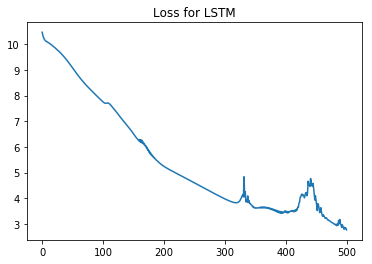

In [2]:
#################################
### Author: Paul Soto 		  ###
### 		paul.soto@upf.edu ###
#								#
# This file shows how to use a ##
# LSTM network with word vectors#
# to predict the next word in a #
# sequence. It is based off of ##
# the code from Nicolas Jimenez #
# https://github.com/nicodjimenez
#################################

import numpy as np 
import itertools
import matplotlib.pyplot as plt

def loss(pred, label, deriv=False):
	if deriv:
		diff = (pred - label)
		return diff
	return 0.5*sum((pred - label) ** 2)

def sigmoid(x, deriv=False):
	if deriv:
		return x*(1-x) 
	return 1. / (1 + np.exp(-x))

def dtanh(x): 
	return 1. - x ** 2

def softmax(x, deriv=False):
	if deriv:
		vec = x.reshape((-1,1))
		jac = np.diag(x) - np.dot(vec, vec.T)
		return jac
	x = x-x.max()
	return np.exp(x)/np.exp(x).sum()

class LSTM:
	"""Class initiates an LSTM model with a forget, input and output gate
	and softmax activation function
	"""
	def __init__(self, x_size, c_size):
		"""
		x_size is size of input
		c_size is size of cell states and hidden states (which is output)
		"""
		self.x_size = x_size
		self.c_size = c_size
		# Theta matrices and bias terms for gates and output
		theta_g = np.random.rand(c_size,x_size+c_size)
		theta_i = np.random.rand(c_size,x_size+c_size)
		theta_f = np.random.rand(c_size,x_size+c_size)
		theta_o = np.random.rand(c_size,x_size+c_size)
		theta_h = np.random.rand(c_size,c_size)
		b_i = np.random.rand(c_size)
		b_f = np.random.rand(c_size)
		b_o = np.random.rand(c_size)
		b_g = np.random.rand(c_size)
		b_h = np.random.rand(c_size)
		self.params = {'theta_g':theta_g,'theta_i':theta_i, 'theta_f':theta_f, 
						'theta_o':theta_o,'theta_h':theta_h, 'b_i':b_i, 'b_f':b_f,
						'b_o':b_o, 'b_g':b_g, 'b_h':b_h}
		### Differentials for each parameter 
		self.deltas = {}
		for param in self.params.keys():
			self.deltas[param+"_delta"] = np.zeros_like(self.params[param])	

	def differentiate(self, lr = 1):
		### Apply the deltas to each weight 
		for param in self.params:
			self.params[param] -= lr*self.deltas[param+"_delta"]
			self.deltas[param+"_delta"] = np.zeros_like(self.params[param])

class LSTM_node:
	"""
	Class for forward propogated and backward propogating cell
	"""
	def __init__(self,param):
		self.param = param

	def forward_prop(self,x,h_prev,c_prev):
		"""
		x is input at time step t
		h_prev is hidden state (output) at time t-1
		c_prev is cell state at time t-1
		"""
		xh = np.hstack((x,h_prev))
		self.xh = xh
		self.i = sigmoid(np.dot(self.param.params["theta_i"],xh)+self.param.params["b_i"])
		self.f = sigmoid(np.dot(self.param.params["theta_f"],xh)+self.param.params["b_f"])
		self.o = sigmoid(np.dot(self.param.params["theta_o"],xh)+self.param.params["b_o"])
		self.g = np.tanh(np.dot(self.param.params["theta_g"],xh)+self.param.params["b_g"])
		self.c = self.f*c_prev+self.i*self.g
		self.z = self.o*np.tanh(self.c)
		self.h = softmax(np.dot(self.param.params['theta_h'],self.z)+self.param.params["b_h"])
		self.h_prev = h_prev
		self.c_prev = c_prev

	def back_prop(self,dh, dc_next):
		"""
		Performs gradient descent
		dh is the derivate of the loss function wrt to h 
		dc_next is the derivative of the loss function wrt to c_{t+1}
		"""
		dz = np.dot(softmax(self.h,deriv=True),dh)
		dc =np.dot(self.param.params['theta_h'].T,dz)*self.o*dtanh(self.c) + dc_next
		do = np.dot(self.param.params['theta_h'].T,dz)*np.tanh(self.c)*sigmoid(self.o,deriv=True)
		di = self.g*sigmoid(self.i,deriv=True)*dc
		df = self.c_prev*sigmoid(self.f, deriv=True)*dc
		dg = self.i*dtanh(self.g)*dc
		self.param.deltas['theta_o_delta'] += np.outer(do, self.xh)
		self.param.deltas['theta_g_delta']  += np.outer(dg, self.xh)
		self.param.deltas['theta_i_delta']  += np.outer(di, self.xh)
		self.param.deltas['theta_f_delta']  += np.outer(df, self.xh)
		self.param.deltas['theta_h_delta']  += np.outer(dz,self.o*np.tanh(self.c))
		self.param.deltas['b_i_delta']  += di
		self.param.deltas['b_f_delta'] += df      
		self.param.deltas['b_o_delta'] += do
		self.param.deltas['b_g_delta'] += dg  
		self.param.deltas['b_h_delta'] += dz  

		dxh = np.zeros_like(self.xh)
		dxh += np.dot(self.param.params['theta_i'].T, di)
		dxh += np.dot(self.param.params['theta_f'].T, df)
		dxh += np.dot(self.param.params['theta_o'].T, do)
		dxh += np.dot(self.param.params['theta_g'].T, dg)
		# Pass the dL/dc to time step at t-1
		# Pass the dL/dh to time step at t-1
		self.dc_prev = dc * self.f
		self.dh_prev = dxh[self.param.c_size:]

def predict_word(sentence, lstm_param):
	x_pred_list = []
	y_pred_list = []
	for sent in [sentence]:
		x_pred_list.append(map(lambda x: vectors[np.where(words==x)[0][0]],
				sent.split()))
	lstm_node_list = []
	# Initiate the LSTM cells and forward propogate
	for ex_ind in range(len(x_pred_list)):
		example = x_pred_list[ex_ind]
		for ind in range(len(example)):
			if len(lstm_node_list)<len(example):
				lstm_node_list.append(LSTM_node(param=lstm_param))
				if ind==0: 
					c_prev = np.zeros(c_size)
					h_prev = np.zeros(c_size)
				else:
					c_prev = lstm_node_list[ind-1].c
					h_prev = lstm_node_list[ind-1].h
				lstm_node_list[ind].forward_prop(example[ind],h_prev, c_prev)
	# Return largest probability word
	probs= lstm_node_list[-1].h
	probs_max = np.where(probs==max(probs))
	return sentence,words[probs_max][0]


docs = ["we think uncertainty about unemployment",
		"uncertainty and fears about inflation",
		"we think fears about unemployment",
		"we think fears and uncertainty about inflation and unemployment",
		"constant negative press covfefe"]

# Split each document into a list of words
docs_split = map(lambda x: x.split(),docs)
docs_words = list(itertools.chain(*docs_split))

# Find unique words across all documents
words = np.unique(docs_words)

# Generate a one hot encoded vector for each unique word
vectors = np.eye(words.shape[0])
x_list = []
y_list = []
for sent in docs_split:
	if len(sent)<2:
		continue
	x_list.append(map(lambda x: vectors[np.where(words==x)[0][0]],sent[:-1]))
	y_list.append(map(lambda y: vectors[np.where(words==y)[0][0]],sent[1:]))

# Initiate the LSTM parameters
x_size  = vectors.shape[0]
c_size  = vectors.shape[0]
np.random.seed(0)
lstm_param = LSTM(x_size, c_size) 

# Training
lstm_node_list = []
losses = []
for epoch in range(500):
	print "epoch number %s" % epoch
	# Loop through each sentence
	for ex_ind in range(len(x_list)):
		example = x_list[ex_ind]
		output = y_list[ex_ind]
		# Each word in the sentence will be a timestep
		# Initiate the lstm_nodes
		for ind in range(len(example)):
			if len(lstm_node_list)<len(example):
				lstm_node_list.append(LSTM_node(param=lstm_param))
				if ind==0: 
					c_prev = np.zeros(c_size)
					h_prev = np.zeros(c_size)
				else:
					c_prev = lstm_node_list[ind-1].c
					h_prev = lstm_node_list[ind-1].h
				lstm_node_list[ind].forward_prop(example[ind],h_prev, c_prev)
		# Backpropogate and update the parameters in lstm_param
		idx = len(example)-1
		if ex_ind ==0: curr_loss = 0
		curr_loss += loss(lstm_node_list[idx].h,output[idx])
		dh_curr = loss(lstm_node_list[idx].h,output[idx],deriv=True)
		lstm_node_list[idx].back_prop(dh_curr, np.zeros(c_size))
		idx-=1
		while idx>=0:
			curr_loss += loss(lstm_node_list[idx].h,output[idx])
			dh = loss(lstm_node_list[idx].h,output[idx],deriv=True)
			dh += lstm_node_list[idx + 1].dh_prev
			dc = lstm_node_list[idx + 1].dc_prev
			lstm_node_list[idx].back_prop(dh, dc)
			idx-=1
		# To stop exploding gradient clip the delta values
		for param in lstm_param.deltas:
			lstm_param.deltas[param] = np.clip(lstm_param.deltas[param],-1,1)
		lstm_param.differentiate(lr=0.1)
		lstm_node_list = []
	losses.append(curr_loss)

# Let's see how well the model predicts the next word in the following sentences
print "'we': %s" % predict_word("we", lstm_param)[1]
print "'we think': %s" % predict_word("we think", lstm_param)[1]
print "'uncertainty and': %s" % predict_word("uncertainty and", lstm_param)[1]
print "'uncertainty and fears about': %s" % predict_word("uncertainty and fears about", lstm_param)[1]

plt.plot(losses)
plt.title("Loss for LSTM")
plt.show()